## Table of Contents
### 1. Daily data & pre-processing
### 2. XGBoost Tuning via GridSearchCV
### 3. Shapley Analytics
### 4. Gradient Boost Regressor Baseline Forecast Establishment via GridSearchCV
### 5. Hourly data functions - to be applied later

In [13]:
# Initial Imports
import pandas as pd
import numpy as np
from pathlib import Path
from dotenv import load_dotenv
import time
from joblib import dump,load # Save Models
from numpy import random
import os
from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt

# SDK Imports
#import tweepy
import shrimpy
#from newsapi import NewsApiClient
import cryptocompare


# NLP Models
#import nltk
#from nltk.sentiment.vader import SentimentIntensityAnalyzer
#nltk.download('vader_lexicon')

# SKLearn Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
#from sklearn.preprocessing import StandardScaler, MinMaxScalar
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
# Tensor Flow Models
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import LSTM, Dense, Dropout

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# HV Plot
#import hvplot.pandas
#import panel as pn
from sklearn.metrics import mean_absolute_error
import requests
import quandl
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
#import hvplot.pandas
import xgboost as xgb
from keras.wrappers.scikit_learn import KerasClassifier
import sys
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import tree
from sklearn.model_selection import GridSearchCV
import numpy as np
from pydataset import data
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.ensemble import AdaBoostRegressor
import shap

In [14]:
# Set environment variables from the .env file
env_path = Path("/Users/gdepa")/'grant_api_keys.env'
load_dotenv(env_path)
# Extract API Keys from environment variables
shrimpy_public_key = os.getenv("SHRIMPY_PUBLIC_KEY")
shrimpy_private_key = os.getenv("SHRIMPY_PRIVATE_KEY")
KRAKEN_API_KEY = os.getenv("KRAKEN_API_KEY")
KRAKEN_PRIVATE_KEY = os.getenv("KRAKEN_PRIVATE_KEY")
#KUCOIN_API_KEY = os.getenv("KUCOIN_API_KEY")
#KUCOIN_PRIVATE_KEY = os.getenv("KUCOIN_SECRET_KEY")
#COINBASE_API_KEY = os.getenv("COINBASE_PRO_API_KEY")
#COINBASE_PRIVATE_KEY = os.getenv("COINBASE_PRO_SECRET_KEY")

# Shrimpy API Client
shrimpy_client = shrimpy.ShrimpyApiClient(shrimpy_public_key, shrimpy_private_key)
# Quandl API Client
q_api = os.getenv("QUANDL_API_KEY")

## 1. Data Pre-Processing
---

### 1.a) Calculate Multi-Factor Daily BTC Dataframe from CryptoCompare Data

In [15]:
def calc_nvt(symbol):
    # Get Into The Block blockchain data from CryptoCompare API
    url = 'https://min-api.cryptocompare.com/data/blockchain/histo/day?api_key=015b242e7bed3700ca69182009d5c7af87bf6b83f7c5a0e12eb5a9b01bee3fb0&limit=2000&fsym=' + symbol
    data = requests.get(url).json()["Data"]["Data"]
    df = pd.DataFrame(data) 
    
    # Calculate 
    df['nvt'] = df['current_supply'] / df['transaction_count'] / df['average_transaction_value']
    
    # Get pricing data from CryptoCompare API
    price_url = 'https://min-api.cryptocompare.com/data/v2/histoday?tsym=USD&limit=2000&api_key=015b242e7bed3700ca69182009d5c7af87bf6b83f7c5a0e12eb5a9b01bee3fb0&fsym=' + symbol
    histo_data = requests.get(price_url).json()["Data"]["Data"]
    
    df_price = pd.DataFrame(histo_data)
    
    combined = df.set_index('time').join(df_price.set_index('time'), on='time')
    
    return combined

def get_social(symbol):
    url = "https://min-api.cryptocompare.com/data/social/coin/histo/day?api_key=015b242e7bed3700ca69182009d5c7af87bf6b83f7c5a0e12eb5a9b01bee3fb0&limit=2000&fsym=" + symbol
    data = requests.get(url).json()[('Data')]
    df = pd.DataFrame(data)
    
    price_url = 'https://min-api.cryptocompare.com/data/v2/histoday?tsym=USD&limit=2000&api_key=015b242e7bed3700ca69182009d5c7af87bf6b83f7c5a0e12eb5a9b01bee3fb0&fsym=' + symbol
    histo_data = requests.get(price_url).json()["Data"]["Data"]
    
    df_price = pd.DataFrame(histo_data)
    
    combined = df.set_index('time').join(df_price.set_index('time'), on='time')
    return combined

def calc_btc_df():
    btc_df = calc_nvt('BTC')
    btc_df.reset_index(inplace = True)
    btc_df['time'] = pd.to_datetime(btc_df['time'], unit = 's')
    btc_df.drop(columns=['id', 'zero_balance_addresses_all_time', 'block_height', 'block_time', 'high', 'low', 'open', 'volumefrom', 'volumeto', 'conversionType', 'conversionSymbol'], inplace = True)
    btc_df.set_index("time", drop=True, inplace=True)
    btc_df['returns']= btc_df['close'].pct_change() 
    btc_df['sma200'] = btc_df.close.rolling(window=200).mean()
    btc_df['mayer_multiple'] = btc_df.close / btc_df.sma200
    
    quandl_mining_df = quandl.get("BITCOINWATCH/MINING", api_key=q_api)
    market_cap = pd.DataFrame(quandl_mining_df['Market Cap'])
    market_cap.reset_index(inplace=True)
    market_cap['time'] = market_cap['Date']
    market_cap.drop(columns='Date',inplace=True)
    market_cap.set_index('time', inplace=True)
        
    #mining_operating_margin = quandl.get("BCHAIN/MIOPM", api_key=q_api)
    #mining_operating_margin.columns = ['mining_op_margin']
    #mining_operating_margin.reset_index(inplace=True)
    #mining_operating_margin['time'] = mining_operating_margin['Date']
    #mining_operating_margin.drop(columns='Date', inplace=True)
    #mining_operating_margin.set_index('time', inplace=True)
    #
    fng_df = pd.DataFrame(requests.get("https://api.alternative.me/fng/?limit=0").json()['data'])
    fng_df['time'] = pd.to_datetime(fng_df['timestamp'], unit = 's')
    fng_df.set_index("time", drop=True, inplace=True)
    fng_df.sort_index(axis=0, ascending=True, inplace=True)
    fng_df.drop(columns=['time_until_update', 'timestamp', 'value_classification'], inplace = True)
    fng_df.columns = ['fng_value']
    fng_df["fng_value"] = pd.to_numeric(fng_df["fng_value"], downcast="float")
    fng_df['fng_value_1d']=fng_df['fng_value'].pct_change()
    fng_df['fng_value_3d']=fng_df['fng_value'].pct_change(3)
    fng_df['fng_value_7d']=fng_df['fng_value'].pct_change(7)
    fng_df['fng_value_sma3_1d'] = fng_df.fng_value_1d.rolling(window=3).mean()
    fng_df['fng_value_sma7_1d'] = fng_df.fng_value_1d.rolling(window=7).mean()
    fng_df.dropna(inplace=True)
    #
    social_df = get_social('BTC')
    social_df.reset_index(inplace = True)
    social_df['time'] = pd.to_datetime(social_df['time'], unit = 's')
    social_df.set_index("time", drop=True, inplace=True)
    social_df = social_df[826:-1]
    social_df = social_df.drop(columns=['high', 'low', 'open', 'volumefrom', 'volumeto', 'conversionType', 'conversionSymbol', 'close', 'analysis_page_views', 'charts_page_views', 'code_repo_closed_issues', 'code_repo_closed_pull_issues', 'code_repo_contributors', 'code_repo_forks', 'code_repo_open_issues', 'code_repo_open_pull_issues', 'code_repo_stars', 'code_repo_subscribers', 'comments', 'fb_likes', 'fb_talking_about', 'followers', 'forum_page_views', 'influence_page_views', 'markets_page_views',
       'overview_page_views', 'points', 'posts', 'reddit_subscribers', 'total_page_views', 'trades_page_views', 'twitter_favourites', 'twitter_following', 'twitter_lists'])
    social_df['reddit_active_users_incr'] = social_df.reddit_active_users.pct_change()
    social_df['reddit_comments_hr_inc'] = social_df.reddit_comments_per_hour.pct_change()
    social_df['reddit_comments_day_inc'] = social_df.reddit_comments_per_day.pct_change()
    social_df['reddit_posts_day_inc'] = social_df.reddit_posts_per_day.pct_change()
    social_df['reddit_posts_hour_inc'] = social_df.reddit_posts_per_hour.pct_change()
    social_df['twitter_followers_incr'] = social_df.twitter_followers.pct_change()
    social_df['twitter_statuses_incr'] = social_df.twitter_statuses.pct_change()
    #
    rev = quandl.get("BCHAIN/MIREV", api_key=q_api)
    rev.columns = ['miners_rev']
    rev.reset_index(inplace=True)
    rev['time'] = rev['Date']
    rev.drop(columns='Date', inplace=True)
    rev.set_index('time', inplace=True)
    #
    btc_df0 = pd.merge(btc_df, market_cap, on=['time'], how='left')
    btc_df1 = pd.merge(btc_df0, fng_df, on=['time'], how='left')
    btc_df2 = pd.merge(btc_df1, rev, on='time', how='left')
    btc_df3 = pd.merge(btc_df2, social_df, on='time', how='left')
    
    btc_df3['address_growth'] = btc_df3['new_addresses']/btc_df3['unique_addresses_all_time']
    btc_df3['perc_mined'] = btc_df3['current_supply']/21000000
    #btc_df3['price_change_1d'] = btc_df3['close'].pct_change(1)
    #btc_df3['price_change_7d'] = btc_df3['close'].pct_change(7)
    #btc_df3['price_change_30d'] = btc_df3['close'].pct_change(30)
    btc_df3.drop(columns=['block_size', 'average_transaction_value', 'difficulty', 'hashrate', 'symbol', 'sma200', 'transaction_count', 
                         'transaction_count_all_time', 'unique_addresses_all_time', 'reddit_active_users', 'twitter_followers', 'twitter_statuses', 'reddit_comments_per_day', 'reddit_comments_per_hour', 'reddit_posts_per_day', 'reddit_posts_per_hour'], inplace=True)
    btc_df3['price_velocity_2d'] = btc_df3['close'].pct_change(2)
    btc_df3['price_velocity_3d'] = btc_df3['close'].pct_change(3)
    btc_df3['price_velocity_4d'] = btc_df3['close'].pct_change(4)
    btc_df3['price_velocity_7d'] = btc_df3['close'].pct_change(7)
    btc_df3['price_velocity_30d'] = btc_df3['close'].pct_change(30)
    btc_df3['price_acceleration_1d'] = btc_df3['returns'].pct_change(1)
    btc_df3['price_acceleration_2d'] = btc_df3['price_velocity_2d'].pct_change(2)
    btc_df3['price_acceleration_3d'] = btc_df3['price_velocity_3d'].pct_change(3)
    btc_df3['price_acceleration_4d'] = btc_df3['price_velocity_4d'].pct_change(4)
    btc_df3['price_acceleration_7d'] = btc_df3['price_velocity_7d'].pct_change(24)
    btc_df3['price_acceleration_30d'] = btc_df3['price_velocity_30d'].pct_change(168)
    btc_df3['ema_7d'] = btc_df3['price_velocity_7d'].ewm(halflife=7).mean()
    btc_df3['ema_30d'] = btc_df3['price_velocity_30d'].ewm(halflife=30).mean()
    btc_df3['ema_crossover_long'] = np.where(btc_df3['ema_7d'] > btc_df3['ema_30d'], 1.0, 0.0)
    btc_df3['ema_crossover_short'] = np.where(btc_df3['ema_7d'] < btc_df3['ema_30d'], 1.0, 0.0)
    btc_df3 = btc_df3.dropna()
    return btc_df3

btc_fng_df = calc_btc_df()
btc_fng_df.head()

,new_addresses,active_addresses,large_transaction_count,current_supply,nvt,close,returns,mayer_multiple,Market Cap,fng_value,...,price_acceleration_1d,price_acceleration_2d,price_acceleration_3d,price_acceleration_4d,price_acceleration_7d,price_acceleration_30d,ema_7d,ema_30d,ema_crossover_long,ema_crossover_short
time,,,,,,,,,,,,,,,,,,,,,
2018-02-08,260103,750412,10564,1.685381e+07,14.386408,8260.69,0.087975,1.034174,1.361462e+11,30.0,...,-7.242679,-2.155150,-1.875284,-1.026415,0.043926,-1.638376,-0.153565,0.121460,0.0,1.0
2018-02-09,279922,778811,10938,1.685550e+07,14.731736,8696.83,0.052797,1.084746,1.434328e+11,44.0,...,-0.399864,0.538602,-1.771577,-2.061773,-0.910929,-1.591293,-0.140936,0.109160,0.0,1.0
2018-02-10,277035,746239,9857,1.685729e+07,10.960623,8569.29,-0.014665,1.064863,1.413641e+11,54.0,...,-1.277764,-0.485735,-2.690307,-1.854901,-0.707243,-1.577283,-0.134599,0.098534,0.0,1.0
2018-02-11,229488,821981,7898,1.685918e+07,12.054280,8084.61,-0.056560,1.001197,1.426904e+11,31.0,...,2.856780,-1.484096,-1.111715,-1.361363,-0.898671,-1.758501,-0.123441,0.086784,0.0,1.0
2018-02-12,289180,918494,10414,1.686125e+07,10.067971,8911.27,0.102251,1.099337,1.470529e+11,42.0,...,-2.807830,0.068258,-0.809265,14.178749,-2.698261,-1.617617,-0.084973,0.076252,0.0,1.0


In [17]:
X = btc_fng_df.copy()
X.drop(["close", "returns"], axis=1, inplace=True)
y = btc_fng_df["returns"].values.reshape(-1, 1)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)
scaler = MinMaxScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
# Fit the MinMaxScaler object with the target data Y
scaler.fit(y)

# Scale the target training and testing sets
y_train_scaled = scaler.transform(y_train)
y_test_scaled = scaler.transform(y_test)

## ML Models: Gradient Boost - Baseline Establishment & Feature Evaluation

In [19]:
GBR=GradientBoostingRegressor()
search_grid={'n_estimators':[500,1000,2000],'learning_rate':[.001,0.01,.1],'max_depth':[1,2,4],'subsample':[.5,.75,1],'random_state':[1]}
search=GridSearchCV(estimator=GBR,param_grid=search_grid,scoring='neg_mean_squared_error',n_jobs=1)

In [20]:
search.fit(X_train_scaled,y_train_scaled)
search.best_params_

{'learning_rate': 0.01,
 'max_depth': 4,
 'n_estimators': 2000,
 'random_state': 1,
 'subsample': 0.75}

In [21]:
search.best_score_

-0.0006749351407424789

In [22]:
GBR2=GradientBoostingRegressor(n_estimators=2000,learning_rate=0.01,subsample=.75,max_depth=4,random_state=1)
score_gbr2=np.mean(cross_val_score(GBR2,X_train_scaled,y_train_scaled,scoring='neg_mean_squared_error',n_jobs=1))

In [23]:
score_gbr2

-0.0006749351407424789

In [24]:
GBR2.fit(X_train_scaled,y_train_scaled)

GradientBoostingRegressor(learning_rate=0.01, max_depth=4, n_estimators=2000,
                          random_state=1, subsample=0.75)

In [25]:
predictions = GBR2.predict(X_test_scaled)
predicted_returns = scaler.inverse_transform(predictions.reshape(-1,1))
real_returns = scaler.inverse_transform(y_test_scaled.reshape(-1, 1))

In [26]:
returns_gbr = pd.DataFrame({
    "Real": real_returns.ravel(),
    "y_test": y_test.ravel(),
    "Predicted": predicted_returns.ravel()
})
returns_gbr.head(5)


,Real,y_test,Predicted
0,0.042554,0.042554,0.033758
1,0.002231,0.002231,0.004743
2,-0.016539,-0.016539,-0.013404
3,-0.381176,-0.381176,-0.120991
4,0.033820,0.033820,0.002339


<AxesSubplot:>

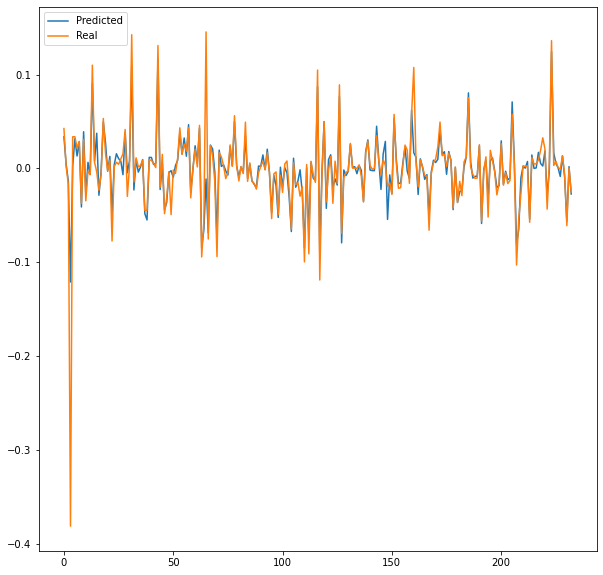

In [27]:
returns_gbr_final = returns_gbr[['Predicted', 'Real']]
returns_gbr_final.plot(figsize=[10,10])

## GBR Forecast

In [16]:
returns_gbr_final['forecast_class_predicted'] = pd.cut(returns_gbr.Predicted,
                     bins=[returns_gbr['Predicted'].min(), -.05, 0, .05, returns_gbr['Predicted'].max()],
                     labels=["very bear", "bear", "bull", "very bull"])
returns_gbr_final['forecast_class_real'] = pd.cut(returns_gbr.Real,
                     bins=[returns_gbr['Real'].min(), -.05, 0, .05, returns_gbr['Real'].max()],
                     labels=["very bear", "bear", "bull", "very bull"])
returns_gbr_final['Accuracy_Test'] = np.where(returns_gbr_final['forecast_class_predicted'] == returns_gbr_final['forecast_class_real'], True, False)
returns_gbr_final.head()

,Predicted,Real,forecast_class_predicted,forecast_class_real,Accuracy_Test
0,0.036381,0.042554,bull,bull,True
1,0.005223,0.002580,bull,bull,True
2,-0.013075,-0.016539,bear,bear,True
3,-0.005763,0.006422,bear,bull,False
4,-0.011707,-0.080036,bear,very bear,False


In [17]:
returns_gbr_final['Accuracy_Test'].value_counts()

True     198
False     34
Name: Accuracy_Test, dtype: int64

In [28]:
accuracy = 198/(198+34)
print(accuracy)

0.853448275862069


### - NOTE - Drill down on quartiles to better understand performance.

https://towardsdatascience.com/multi-state-lstms-for-categorical-features-66cc974df1dc
"But as we discussed in a previous post, when real randomness is associated with the targets (here, predicting human behavior) we get a better assessment of the performance of a classifier by looking at its reliability measure (REL).
Reliability is computed by sorting the data into bins of similar predicted probabilities. Then, we compute an MSE for each bin against the average target in the bin. Finally, we take an overall average to get our REL value."


## ADABoost Grid Search

In [19]:
ABR = AdaBoostRegressor()
# define the grid of values to search
grid = dict()
grid['n_estimators'] = [10, 50, 100, 500,1000]
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
#grid['max_depth'] = [1,2,4,8]
grid['random_state'] =[1]
# define the evaluation procedure
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define the grid search procedure
grid_search_ABR = GridSearchCV(estimator=ABR, param_grid=grid, n_jobs=-1, scoring='neg_mean_squared_error')
# execute the grid search

In [20]:
grid_search_ABR.fit(X_train_scaled,y_train_scaled)
grid_search_ABR.best_params_

{'learning_rate': 1.0, 'n_estimators': 100, 'random_state': 1}

In [21]:
ABR2=AdaBoostRegressor(n_estimators=50,learning_rate=1,random_state=1)
score_abr=np.mean(cross_val_score(ABR2,X_train_scaled,y_train_scaled,scoring='neg_mean_squared_error',n_jobs=1))

In [22]:
score_abr

-0.0016775742100113423

## GBR Feature Importance

In [23]:
importances = GBR2.feature_importances_

In [24]:
importances_df = pd.DataFrame(sorted(zip(GBR2.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True) 
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)

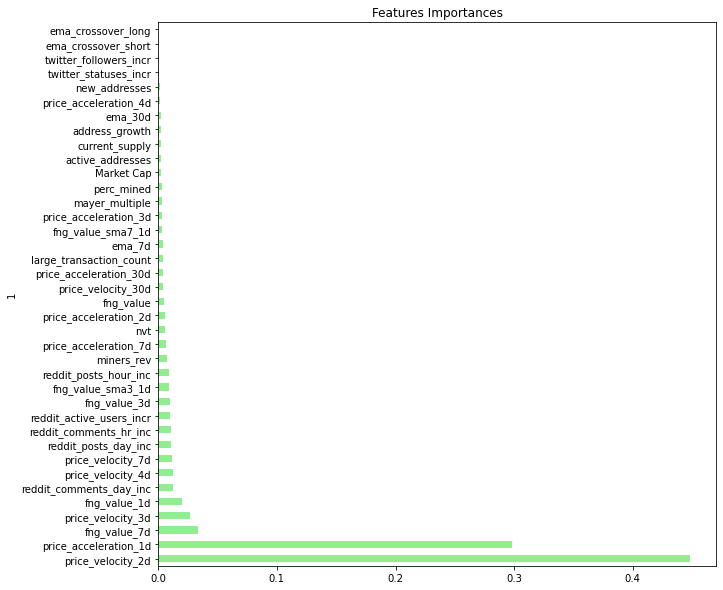

In [25]:
# Sort importances
importances_sorted = importances_df.sort_values(by='Feature Importances', ascending=False)

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False, figsize=[10,10])

## XG Boost Dev 
#### Additional code resources:
#### ** https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f
#### ** https://mlfromscratch.com/gridsearch-keras-sklearn/#/

In [19]:
import xgboost as xgb

In [12]:
# Algo Grid Search Function
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='neg_mean_squared_error',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
      pred = fitted_model.predict_proba(X_test_data)
    else:
      pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred

In [29]:
model = xgb.XGBRegressor()
param_grid = {
    'n_estimators': [400, 700, 1000],
    'colsample_bytree': [0.7, 0.8],
    'max_depth': [15,20,25],
    'reg_alpha': [1.1, 1.2, 1.3],
    'reg_lambda': [1.1, 1.2, 1.3],
    'subsample': [0.7, 0.8, 0.9]
}

model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, 
                                 param_grid, cv=5)

# Root Mean Squared Error
print(np.sqrt(-model.best_score_))
print(model.best_params_)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   51.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed:  5.5min finished


0.03170020853083413
{'colsample_bytree': 0.8, 'max_depth': 15, 'n_estimators': 700, 'reg_alpha': 1.1, 'reg_lambda': 1.1, 'subsample': 0.9}


In [20]:
xgb=xgb.XGBRegressor(n_estimators=700,colsample_bytree=0.8,subsample=.9,max_depth=15,reg_alpha=1.1, reg_lambda=1.1,random_state=1)

In [15]:
def forecast(X_train,y_train, X_test, y_test):
    #Input optimized SearchGrid Params
    model=xgb.XGBRegressor(n_estimators=700,colsample_bytree=0.8,subsample=.9,max_depth=15,reg_alpha=1.1, reg_lambda=1.1,random_state=1)
    #Develop Forecast
    model.fit(X_train, y_train)
    predictions = model.predict(X_train, y_train)
    predicted_returns = predictions.reshape(-1,1)
    real_returns = y_test.reshape(-1, 1)
    #Generate Dataframe
    returns = pd.DataFrame({"Real": real_returns.ravel(),"y_test": y_test.ravel(),"Predicted": predicted_returns.ravel()})
    returns['forecast_class_predicted'] = pd.cut(returns.Predicted,
                     bins=[returns['Predicted'].min(), -.05, 0, .05, returns_gbr['Predicted'].max()],
                     labels=["very bear", "bear", "bull", "very bull"])
    returns['forecast_class_real'] = pd.cut(returns.Real,
                     bins=[returns['Real'].min(), -.05, 0, .05, returns['Real'].max()],
                     labels=["very bear", "bear", "bull", "very bull"])
    returns['Accuracy_Test'] = np.where(returns['forecast_class_predicted'] == returns['forecast_class_real'], True, False)
    return returns

In [16]:
forecast = forecast(X_train,y_train, X_test, y_test)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
model=xgb.XGBRegressor(n_estimators=700,colsample_bytree=0.8,subsample=.9,max_depth=15,reg_alpha=1.1, reg_lambda=1.1,random_state=1)

In [20]:
model.fit(X_train,y_train)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   48.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed:  5.6min finished


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=...
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
                                    verbosity=None),
             n_

In [21]:
predictions_x = model.predict(X_test)
predicted_returns = predictions_x.reshape(-1,1)
real_returns = y_test.reshape(-1, 1)

In [ ]:
predictions = GBR2.predict(X_test_scaled)
predicted_returns = scaler.inverse_transform(predictions.reshape(-1,1))
real_returns = scaler.inverse_transform(y_test_scaled.reshape(-1, 1))

In [22]:
returns_x = pd.DataFrame({
    "Real": real_returns.ravel(),
    "y_test": y_test.ravel(),
    "Predicted": predicted_returns.ravel()
})
returns_x.head(5)


,Real,y_test,Predicted
0,-0.002069,-0.002069,0.008343
1,-0.013983,-0.013983,-0.009074
2,0.051228,0.051228,0.030261
3,0.001878,0.001878,-0.012830
4,0.000924,0.000924,-0.007734


In [ ]:
returns_gbr_final['forecast_class_predicted'] = pd.cut(returns_gbr.Predicted,
                     bins=[returns_gbr['Predicted'].min(), -.05, 0, .05, returns_gbr['Predicted'].max()],
                     labels=["very bear", "bear", "bull", "very bull"])
returns_gbr_final['forecast_class_real'] = pd.cut(returns_gbr.Real,
                     bins=[returns_gbr['Real'].min(), -.05, 0, .05, returns_gbr['Real'].max()],
                     labels=["very bear", "bear", "bull", "very bull"])
returns_gbr_final['Accuracy_Test'] = np.where(returns_gbr_final['forecast_class_predicted'] == returns_gbr_final['forecast_class_real'], True, False)
returns_gbr_final.head()

## Shapley Analytics

In [18]:
shap.initjs()

In [11]:
xgb_full = xgb.DMatrix(X, label=y)
xgb_train = xgb.DMatrix(X_train, label=y_train)
xgb_test = xgb.DMatrix(X_test, label=y_test)

## FUNCTIONS FOR HOURLY PRICING

In [ ]:
    
def get_exchange_data(exchange, interval, start):
    # Get Digital Asset Data
def get_exchange_assets(exchange):
    exchange_assets = shrimpy_client.get_exchange_assets(exchange)
    exchange_assets_df = pd.DataFrame(columns=['id','name', 'symbol', 'trading_symbol'])
    for key, value in enumerate(exchange_assets):
        exchange_assets_df.loc[key] = [value['id'], value['name'], value['symbol'], value['tradingSymbol']]
    return exchange_assets_df

def calc_trading_pairs_df(exchange):
    exchange_pairs = shrimpy_client.get_trading_pairs(exchange)
    exchange_pairs_df = pd.DataFrame(columns=['base','quote'])
    for key, value in enumerate(exchange_pairs):
        exchange_pairs_df.loc[key] = [value['baseTradingSymbol'],value['quoteTradingSymbol']]
    return exchange_pairs_df

def get_prices(exchange, interval, start):
    trading_pairs_df = calc_trading_pairs_df(exchange)
    master_prices_df = pd.DataFrame()
    for index, row in trading_pairs_df.iterrows():
        candles = shrimpy_client.get_candles(exchange, row['base'], row['quote'], interval, start)
        time = []
        prices = []
        for key, value in enumerate(candles):
            time.append(value['time'])
            prices.append(value['close'])
        prices_df = pd.DataFrame(list(zip(time, prices)), columns = ['time', row['base'] + "_" + row['quote']])
        prices_df['time'] = pd.to_datetime(prices_df['time'])
        if master_prices_df.empty:
            master_prices_df = prices_df
        else:
            master_prices_df = pd.merge(master_prices_df, prices_df, left_on='time', right_on = 'time', how = 'left')
    return master_prices_df
    return get_exchange_assets(exchange), calc_trading_pairs_df(exchange), get_prices(exchange, interval, start)

In [7]:
def calc_btc_df():
    candles = shrimpy_client.get_candles('kraken', 'XBT', "USD",'1h', '2016-01-01')
    time = []
    prices = []
    for key, value in enumerate(candles):
        time.append(value['time'])
        prices.append(value['close'])
    prices_df = pd.DataFrame(list(zip(time, prices)), columns = ['time', 'close'])
    prices_df['time'] = pd.to_datetime(prices_df['time'])
    prices_df = prices_df.set_index('time') # set index to time
    prices_df['close'] = prices_df['close'].apply(pd.to_numeric) # Convert Prices to Floats
    prices_df['close'] = prices_df['close'].fillna(method='backfill') # Backfill null values
    

    prices_df['price_velocity_1h'] = prices_df['close'].pct_change(1)
    prices_df['price_velocity_2h'] = prices_df['close'].pct_change(2)
    prices_df['price_velocity_3h'] = prices_df['close'].pct_change(3)
    prices_df['price_velocity_4h'] = prices_df['close'].pct_change(4)
    prices_df['price_velocity_24h'] = prices_df['close'].pct_change(24)
    prices_df['price_velocity_168h'] = prices_df['close'].pct_change(168)
    prices_df['price_acceleration_1h'] = prices_df['price_velocity_1h'].pct_change(1)
    prices_df['price_acceleration_2h'] = prices_df['price_velocity_2h'].pct_change(2)
    prices_df['price_acceleration_3h'] = prices_df['price_velocity_3h'].pct_change(3)
    prices_df['price_acceleration_4h'] = prices_df['price_velocity_4h'].pct_change(4)
    prices_df['price_acceleration_24h'] = prices_df['price_velocity_24h'].pct_change(24)
    prices_df['price_acceleration_168h'] = prices_df['price_velocity_168h'].pct_change(168)
    prices_df['ema_9h'] = prices_df['price_velocity_1h'].ewm(halflife=9).mean()
    prices_df['ema_21h'] = prices_df['price_velocity_1h'].ewm(halflife=21).mean()
    prices_df['ema_crossover_long'] = np.where(prices_df['ema_9h'] > prices_df['ema_21h'], 1.0, 0.0)
    prices_df['ema_crossover_short'] = np.where(prices_df['ema_9h'] < prices_df['ema_21h'], 1.0, 0.0)
    return prices_df

In [ ]:
exchange = 'kucoin'
interval = '1h'
start = '2020-01-01'

assets,piars,prices = get_exchange_data(exchange, interval,start)

In [13]:
prices.set_index('time', inplace=True)
prices.fillna(method="ffill", inplace=True)

### Digital Asset Multi-Factor Data Frames

In [ ]:
exchange = 'kucoin'
interval = '1h'
start = '2020-01-01'

assets,piars,prices = get_exchange_data(exchange, interval,start)

In [22]:
btc_prices_1h.fillna(method="ffill",inplace=True)
btc_prices_1h['returns'] = btc_prices_1h.close.pct_change()
btc_prices_1h.dropna(inplace=True)